# Names 
Student 1: Sarah Khan (skhan102)

Student 2: Disha Mishra (dmishra4) 

# Heart rate estimation, signal de-noising and mobile health
The goal of this lab is to study an algorithm for correctly retrieving the timing instants of an ECG (EKG) time series. We will implement a simplified variant of the [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029) and we will test it on real ECG data recordings. Towards the end of the lab you will be asked to apply your algorithms to the problem of heart rate estimation using a mobile device.

### Objectives
By the end of this session you should be able to understand the main challenges in the estimation of EGC signals. How to work from modeling assupmtions in order to exploit your prior knowledge in the estimation task.

***

### Signal generation and template matching
In this task we will implement a simple version of a QRS-complex detector by using template matching, thresholding and non-maximum suppresion on the
observed ECG signal. We will then use those detections to provide an estimate of the heart rate.

* **Signal Generation -** We are going to create a synthetic EGC signal that we will be using to test our detector algorithm. For that purpose generate a stream of $10$ equally spaced pulses over a time span of $10\ s$.  Each pulse should have a sampling rate of $f_s = 256\ Hz$. The goal of this task is to create a basic model for a ECG signal. You can think of the signal as the convolution of a canonical pulse shape $\varphi(t)$ with a stream of Dirac delta functions: 

   $$x(t) = \sum_{k=1}^K a_k\, \varphi(t-t_k) = \varphi(t) \ast \sum_{k=1}^K a_k\, \delta(t-t_k),$$ 

   where $K$ is the number of pulses observed, $a_k$ represent the amplitudes of the different pulses and $t_k$ correspond to the locations of the pulses in time. For the purpose of this task use the canonical pulse shape generated by the `ecg_wave()` function defined in the notebook and constant unit amplitudes $a_k=1$. Plot the generated signal over time adding the appropriate labels for the axis.


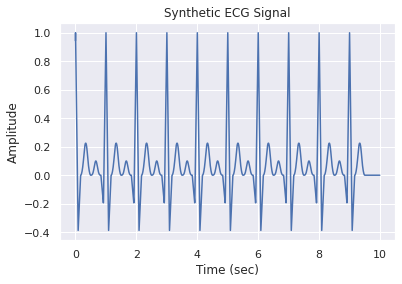

In [44]:
# ============================================================================
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell

import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

# inline plots
%matplotlib inline
sns.set()

# ============================================================================
# functions
# ============================================================================
def ecg_wave(x):
    """
    This function generates a single synthetic ECG template of unit length (support).
    For example, for a sampling frequency of f_s, use x = np.linspace(0,1, f_s, endpoint=False)
    """
    
    # compute signal (superposition of splines)
    return 0.3 * signal.bspline(3*3*x-7.5,2)\
         + 0.15* signal.bspline(3*4*x-2,3)\
         + signal.bspline(3*2*2*x-6,1) - 0.2 * signal.bspline(3*4*x-5,1) - 0.4 * signal.bspline(3*4*x-7,1)


# ============================================================================
# Start your code below this line
# ============================================================================
# ...
f_s = 256; # sampling frequency of 256 Hz
t = np.linspace(0,1,f_s, endpoint=False); # linspace generates a certain number
# of values between some start and end time 
y = ecg_wave(t);
#plt.plot(t,y);

x = np.zeros(256 * 10);
for i in range(0, 10): 
  x[i * 256] = 1;



tenPulses = np.convolve(x, y, 'same');
newT = np.linspace(0,10, len(tenPulses));
plt.plot(newT, tenPulses);
plt.xlabel("Time (sec)");
plt.ylabel("Amplitude");
plt.title("Synthetic ECG Signal");

* **Simulate Noise -** Generate a noisy version of the synthetic ECG signal generated by adding Gaussian noise with standard deviation $\sigma=0.5$. Plot the noisy observations.

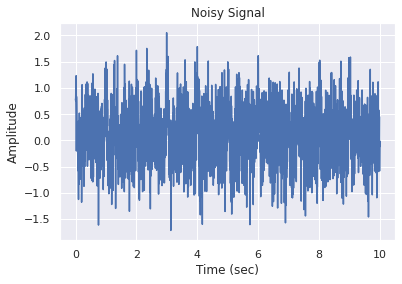

In [45]:
# ============================================================================
# Write your code here
# ============================================================================
# ...
#use randn function from the prelab 
# generate 2560 random numbers that are Gaussian distrubuted with a sigma 0.5 
# add this to the wave
# make a list that stores np.randn with a mean of zero and standard dev of 0.5 and length of signal 
noise = np.random.normal(0, 0.5, len(tenPulses));
noisyTenPulses = tenPulses + noise;
plt.figure();
newNewT = np.linspace(0,10, len(tenPulses));
plt.plot(newNewT, noisyTenPulses);
plt.xlabel("Time (sec)");
plt.ylabel("Amplitude");
plt.title("Noisy Signal");

* **Find Peaks -** Implement a QRS-complex detector on the noisy signal you just generated. For that purpose we will use template matching, thresholding, and non-maximum suppression. First you should implement template matching by correlating the noisy signal with a template ECG pulse using `np.correlate`.   We recommend that you normalize the signal to range $[0,1]$ using `noralize_range` before thresholding. Then plot the result. Next choose a threshold value and keep only those values of the signal that are above the given threshold. Once you have done that, perform a non-maximum suppression (i.e., keep a value if it is greater than the previous and following values). To implement the thresholding and non-maximum suppression operations you can use `signal.find_peaks` function with the `height` parameter set to the your chosen threshold.  Print the times of each peak in seconds.

Correlate the noisy signal we just generated with the original single wave and normalize that result. 

The peaks occur at the following times (in seconds): 
[0.01171875 1.00390625 2.01171875 2.359375   3.0078125  4.01171875
 5.00390625 6.         7.00390625 8.01171875 9.00390625]


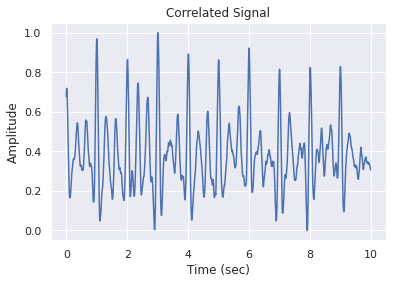

In [46]:
import numpy as np
def normalize_range(x):
    """
    Normalizes the signal such that its minimum value is 0 and its maximum value is 1,
    provided the signal is not identically zero.
    """
    # check that there are non-zero elements
    if np.any(x):
        
        # subtract minimum
        minx = np.min(x)
        z = x - minx
        
        # divide by max value
        maxz = np.max(z)
        return z/maxz
    
    else:    
        return x
    
# ============================================================================
# Start your code below this line
# ============================================================================
# ...
# the correlation will be highest when the template wave lines up with the noisy wave 
correlated = normalize_range(np.correlate(noisyTenPulses, y, mode = 'same'));
correlatedT = np.linspace(0,10, len(correlated));
# plot correlated plot 
plt.plot(correlatedT, correlated); 
plt.xlabel("Time (sec)");
plt.ylabel("Amplitude");
plt.title("Correlated Signal");
# set threshold value of 0.75 
# needs the underscore because we are only interested in the first part of return value
thresholdedSignal, _ = signal.find_peaks(correlated, 0.70);
thresholdedSignal = thresholdedSignal / 256;
print("The peaks occur at the following times (in seconds): ");
print(thresholdedSignal); # gives is the times that the peaks occur 



* **RR Intervals -** Plot the original (synthetic) ECG signal as well as the locations of the peaks to verify your method. Keep in mind to compensate for any delay you might have introduced by filtering. From the peak binary signal, estimate the $RR$ interval sequence $r_n$ and its average value as:

$$ \bar R = \frac{1}{N}\sum_{n=0}^N r_n, $$

where $N$ is the number intervals between peaks. Provide an estimate of the average heart beat rate in beats per minute $[bpm]$.


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[0.9921875, 1.0078125, 0.34765625, 0.6484375, 1.00390625, 0.9921875, 0.99609375, 1.00390625, 1.0078125, 0.9921875]
The R Average is  0.9991319444444444
The bpm based on the sample is:  60.052128583840144


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


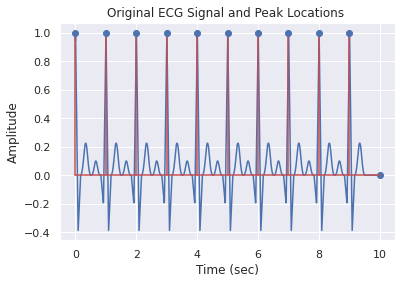

In [47]:
# ============================================================================
# Write your code here
# ============================================================================
# ...
# plot original ECG wave
import math;
plt.figure();
plt.plot(newT ,tenPulses); 
times = np.zeros(11);

# create function that is 1 where the peaks are and 0 elsewhere
for i in range(len(thresholdedSignal - 1)):
  tempTime = thresholdedSignal[i];
  tempTime = int(round(tempTime));
  #print(tempTime);
  times[tempTime] = 1;
print(times);
# plot where peaks occur

timesT = np.linspace(0, 10, len(times));
plt.stem(timesT, times, '-r');
plt.xlabel("Time (sec)");
plt.ylabel("Amplitude");
plt.title("Original ECG Signal and Peak Locations ");

# find distance between each R-wave
rVals = [];
sum = 0; 
# add to find RR
for i in range(1,len(thresholdedSignal)): 
  rVals.append(thresholdedSignal[i] - thresholdedSignal[i-1]);
  sum = sum + thresholdedSignal[i] - thresholdedSignal[i-1]
print(rVals)
# average of RR 
RAverage = sum / 9; 
print("The R Average is ", RAverage);

# find BPM
bpm = 60 / RAverage;
print("The bpm based on the sample is: ", bpm);



### QRS complex detection via Pan-Tompkins algorithm
Now let us consider a more realistic scenario where we have a noisy ECG signal where we don't know a priori the shape of the QRS-complex waveform. There are different
sources of noise that can be present during an ECG acquisition. In addition to high-frequency thermal
noise, it is also common to observe the presence of low-frequency interference coming from breathing. 
When it comes to pathologies, different non-additive distortions might be present on the ECG signal 
that alter the shape of the QRS-complex itself but for the purpose of this task we just assume a healthy 
individual where signal distortion comes solely from the acquisition process. The procedure that we
will employ in order to estimate the locations of the QRS-complex is based on the Pan-Tompkins
algorithm [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029).

* **Effect of noise** - Load the signal **ecg_mitnst.json**  You may have to change `path` to point to the correct loation where you downloaded **ecg_mitnst.json**. The loaded `data` dictionary will contain four fields.  `fs` is the sampling frequency, `voltage` is the measured voltage in *mV* at corresponding `time` points and `t_k` contains the indices of the peaks.  Plot the voltage over time with the given peaks. The signal corresponds to a sample ECG from the [MIT noise stress dataset](https://physionet.org/physiobank/database/nstdb/)
that has been downloaded from [physionet.org](https://physionet.org/physiobank/database/).
Plot the signal and observe the presence of a strong low-frequency component.

In [48]:
# ============================================================================
# Edit path variable below if necessary
# ============================================================================

try:
    # Executes if running in Google Colab
    from google.colab import drive
    drive.mount('gdrive/')
    path = 'gdrive/My Drive/ecg_mitnst.json' # Change path to location of data
except:
    # Executes if running locally (e.g. Anaconda)
    path = 'ecg_mitnst.json' # Change path to location of data

with open(path,'r') as infile: data = json.load(infile)

# print data to see dictionary fields
print(data.keys())

Drive already mounted at gdrive/; to attempt to forcibly remount, call drive.mount("gdrive/", force_remount=True).
dict_keys(['fs', 'time', 'tk', 'voltage'])


Text(0.5, 1.0, 'Voltage vs. Time')

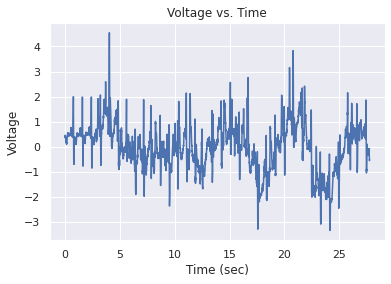

In [49]:
# ============================================================================
# Write your code here
# ============================================================================
#
# plot voltage vs. time
t = data["time"];
mV = data["voltage"];
mV -= np.mean(mV);
plt.plot(t,mV);
plt.xlabel("Time (sec)");
plt.ylabel("Voltage");
plt.title("Voltage vs. Time")


* **Pan-Tompkins Algorithm -** In order to deal with noise we will implement a simplified version of the Pan-Tompkins algorithm. For that purpose proceed as follows:

  1. _Bandpass filtering:_ Follow the steps described in the instructions in order to perform a bandpass filtering operation as the concatenation of lowpass and highpass filtering operations.  For your convinence we have provided `boxFilter` and `triangleFilter` functions.
  
  2. _Differentiation:_ Use the discrete filter $d_n$ to approximate the derivative of the underlying signal:
  
    $$ d_n = \frac{1}{8}\big(\delta_{n-2} + 2\delta_{n-1} -2\delta_{n+1} - \delta_{n+2}\big) $$
  
    The filter is intended to localize the steepest region in the QRS-complex.
  
  3. _Signal squaring:_ Square the obtained signal after differentiation and plot the obtained waveform.
  
  3. _Integration:_ Integrate the resulting signal from the squaring operation with a box window of length $L=50$. Display the resulting signal.
  
  4. _Peak detection:_ Use a peak detector to estimate the locations of the peaks add them to the previous plot. Estimate the sequence of **RR** intervals and plot the corresponding heart beat rate over time.
 

[ 279  575  869 1166 1458 1729 2025 2311 2589 2825 3131 3421 3721 3990
 4278 4486 4844 5136 5443 5727 5995 6331 6615 6907 7207 7499 7774 8094
 8391 8690 8998 9289 9592 9892]
average R is:  0.8091750841750842
BPM from sample is:  74.14958909809633



 BPM per interval values
[72.97297297297298, 73.46938775510205, 72.72727272727273, 73.97260273972603, 79.70479704797049, 72.97297297297298, 75.52447552447553, 77.6978417266187, 91.52542372881356, 70.58823529411765, 74.48275862068965, 72.0, 80.29739776951672, 75.0, 103.84615384615385, 60.33519553072625, 73.97260273972603, 70.35830618892508, 76.05633802816902, 80.59701492537313, 64.28571428571428, 76.05633802816902, 73.97260273972603, 72.0, 73.97260273972603, 78.54545454545455, 67.5, 72.72727272727273, 72.24080267558529, 70.12987012987013, 74.22680412371133, 71.2871287128713, 72.0]






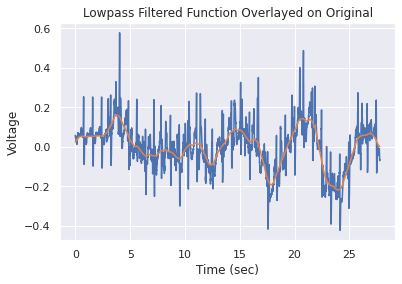

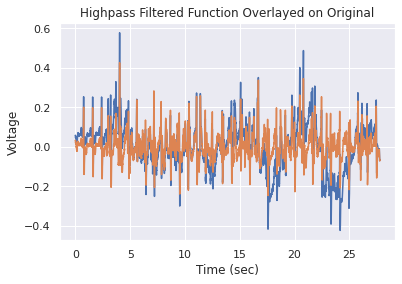

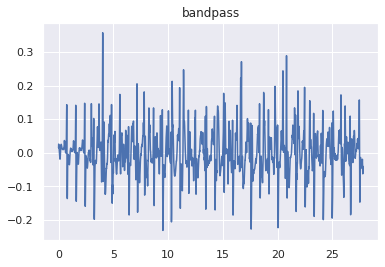

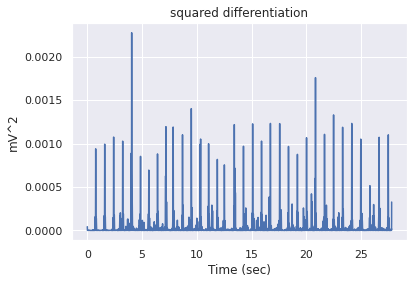

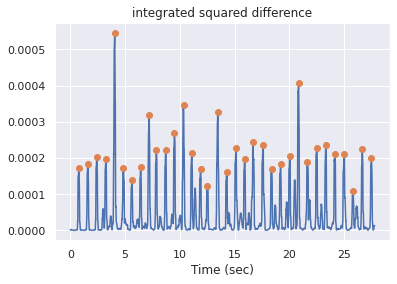

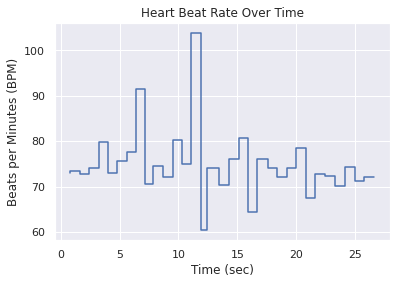

In [50]:
def boxFilter(L):
    """
    Genearte box filter of length L
    """
    h = np.ones(L)
    return h/np.sum(h)

def triangleFilter(L):
    """
    Generate triangle filter of length L
    """
    h = np.convolve(boxFilter(L//2), boxFilter(L//2))
    h = np.concatenate(([0],h))
    if L % 2: h = np.concatenate((h,[0]))
    return h/np.sum(h)


# ============================================================================
# Write your code here
# ============================================================================
# perform lowpass filtering, convolve w/ triangle filter
L = 500;
normV = normalize_range(mV);
time = data['time'];
normV -= np.mean(normV);
lowPass = np.convolve(triangleFilter(L), normV, mode = 'same');
highPass = normV - lowPass;  
# plot lowpass filtered function
plt.figure()
plt.plot(time, normV)
plt.plot(time, lowPass);
plt.xlabel("Time (sec)");
plt.ylabel("Voltage");
plt.title("Lowpass Filtered Function Overlayed on Original");
# plot lowpass filtered function
plt.figure()
plt.plot(time, normV);
plt.plot(time, highPass);
plt.xlabel("Time (sec)");
plt.ylabel("Voltage");
plt.title("Highpass Filtered Function Overlayed on Original");
#Find V_highpass by subtracting V_lowpass from V
#Find V_bandpass by convolving with box filter
bandPass = np.convolve(highPass, boxFilter(10),mode='same');
plt.figure();
plt.title("bandpass");
plt.plot(time, bandPass);

# differentiate by convolving signal with given dn
dn = [1/8, 2/8, 0, -2/8, -1/8] ;
diff = np.convolve(dn, bandPass, mode = 'same');

# square the values of the differential list
squareDiff = [i ** 2 for i in diff];
plt.figure();
plt.title("squared differentiation");
plt.plot(time, squareDiff);
plt.xlabel("Time (sec)");
plt.ylabel("mV^2");


# integrate by convolving box filter with differentiated value 
#intDiff = np.convolve(boxFilter(50), diff, mode = 'same');
intDiff = np.convolve(boxFilter(50), squareDiff, mode = 'same');
plt.figure()
plt.title("integrated squared difference")
plt.xlabel("Time (sec)");
plt.plot(time, intDiff);

# find times associated with the peaks of r 
newPeaks = signal.find_peaks(intDiff, height=.0001, distance=200)[0]
peakTimes = newPeaks / 360;
newPeaks1 = signal.find_peaks(intDiff, height=.0001, distance=200)[1]['peak_heights']
plt.plot(np.array(time)[newPeaks], newPeaks1, 'o');

print(newPeaks);
# find the averaga R value 
averageR = (newPeaks[len(newPeaks) - 1] - newPeaks[0]) / (len(newPeaks) - 1);
averageR = averageR / 360; #since the sampling frequency is 360 Hz
print("average R is: ", averageR);
sampleBPM = 60 / averageR; 
print("BPM from sample is: ", sampleBPM);

#plot the bpm given by each interval, should look like a step wave

# plotting 
bpmPerInterval = []; 

for i in range(1, len(newPeaks)):
  tempIntervalFreq = newPeaks[i] - newPeaks[i - 1];
  tempIntervalTime = tempIntervalFreq / 360; 
  tempBPM = 60 / tempIntervalTime;
  bpmPerInterval.append(tempBPM);
print("\n\n\n BPM per interval values");
print(bpmPerInterval);
print("\n\n\n");

plt.figure();
plt.step(peakTimes[range(len(bpmPerInterval))],bpmPerInterval);
plt.xlabel("Time (sec)");
plt.ylabel("Beats per Minutes (BPM)");
plt.title("Heart Beat Rate Over Time");

